In [1]:
import os, sys
sys.path.insert(0, os.path.abspath(os.path.join("..", "..")))

# Grid based SEPP method(s)

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sepp.sepp_grid
import open_cp.logger
open_cp.logger.log_to_true_stdout("sepp")

# With real data

In [3]:
import opencrimedata.chicago
import open_cp.sources.chicago
import open_cp.geometry
import descartes
import pickle, lzma, datetime
import open_cp.predictors
import open_cp.kernels

In [4]:
#datadir = os.path.join("/media", "disk", "Data")
datadir = os.path.join("..", "..", "..", "..", "..", "Data")
with lzma.open(os.path.join(datadir, "chicago_redist_network_flow_to_buildings_network.csv.xz"), "rt") as file:
    all_points = opencrimedata.chicago.load_to_open_cp(file, "BURGLARY")

In [5]:
open_cp.sources.chicago.set_data_directory(datadir)
northside = open_cp.sources.chicago.get_side("North")
grid = open_cp.data.Grid(150, 150, 0, 0)
grid = open_cp.geometry.mask_grid_by_intersection(northside, grid)

In [6]:
mask = (all_points.timestamps >= np.datetime64("2016-01-01")) & (all_points.timestamps < np.datetime64("2017-01-01"))
points = all_points[mask]
points = open_cp.geometry.intersect_timed_points(points, northside)

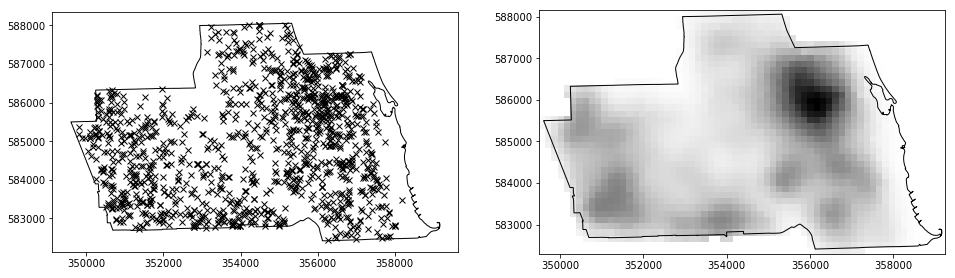

In [7]:
fig, axes = plt.subplots(ncols=2, figsize=(16,10))

ax = axes[0]
ax.add_patch(descartes.PolygonPatch(northside, fc="none"))
ax.set_aspect(1)
ax.scatter(points.xcoords, points.ycoords, marker="x", color="black", linewidth=1)

kernel = open_cp.kernels.GaussianBase(points.coords)
kernel.bandwidth = 300
kernel.covariance_matrix = [[1,0], [0,1]]
pred = open_cp.predictors.grid_prediction_from_kernel_and_masked_grid(kernel, grid, samples=5)
ax = axes[1]
ax.add_patch(descartes.PolygonPatch(northside, fc="none"))
ax.set_aspect(1)
ax.pcolor(*pred.mesh_data(), pred.intensity_matrix, cmap="Greys", rasterized=True)
None

## Continue with analysis

In [8]:
#def add_random_noise(points):
#    ts = points.timestamps + np.random.random(size=points.timestamps.shape) * 60 * 1000 * np.timedelta64(1,"ms")
#    ts = np.sort(ts)
#    return points.from_coords(ts, points.xcoords, points.ycoords)

def add_random_noise(points):
    return points

In [9]:
trainer = sepp.sepp_grid.ExpDecayTrainer(grid)
trainer.data = add_random_noise(points)
model = trainer.train(datetime.datetime(2017,1,1), iterations=50)

In [10]:
model

ExpDecayModel(T=365.9583333333333, theta=0.013983774446459946, omega=6.396482947508833, mu size=(39, 65)

In [11]:
pred = trainer.prediction_from_background(model)

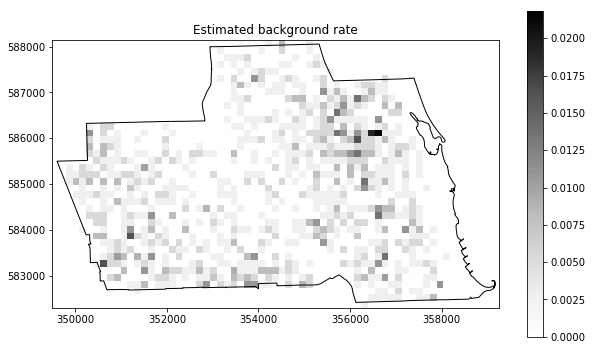

In [12]:
fig, ax = plt.subplots(figsize=(10,6))

ax.add_patch(descartes.PolygonPatch(northside, fc="none"))
ax.set_aspect(1)
mappable = ax.pcolor(*pred.mesh_data(), pred.intensity_matrix, cmap="Greys", rasterized=True)
fig.colorbar(mappable, ax=ax)
ax.set_title("Estimated background rate")
None

In [13]:
np.max(model.mu), np.min(model.mu)

(0.021860388323849265, 0.0)

Unfortunately, the predicted parameters are not very "realistic".  The triggering kernel is
$$ g(t) = \theta \omega e^{-\omega t} $$
with time measured in "days".  We estimate $1 / \omega \approx 225$ _minutes_, and $\theta$ comparable to the background rate.   This means that events need to be very near in time before the triggering kernel adds much.

In [14]:
trainer = sepp.sepp_grid.ExpDecayTrainer(grid)
trainer.data = add_random_noise(points)
model = trainer.train(datetime.datetime(2017,1,1), iterations=50, use_fast=False)

In [15]:
model

ExpDecayModel(T=365.9583333333333, theta=0.013987852740683976, omega=6.391567421668372, mu size=(39, 65)

In [16]:
24 * 60 / model.omega

225.29684895729707

## With old code

Check that we get the same result with the main `open_cp` code.  (For a while, this had poorly chosen initial conditions, which lead to convergence problems.  I've now fixed this.)

In [17]:
import open_cp.seppexp

In [18]:
trainer = open_cp.seppexp.SEPPTrainer(grid=grid)
trainer.data = add_random_noise(points)
predictor = trainer.train(iterations=50)

In [19]:
predictor.theta, predictor.omega * 60 * 24

(0.013965133996888967, 6.4151327819422939)

In [20]:
predictor = trainer.train(iterations=50, use_corrected=True)

In [21]:
predictor.theta, predictor.omega * 60 * 24

(0.014000755043048773, 6.3900665274079076)

## Allowing repeats

We'll also bin the data to the nearest day (moving to noon each day).

Notice that $\theta$ is now tiny!  Indeed, using either edge correction or not, if we run the algorithm for longer, then $\theta$ tends to 0.

In [22]:
pts = points.bin_timestamps(np.datetime64("2017-01-01T12:00"), np.timedelta64(1, "D"))

In [23]:
trainer = sepp.sepp_grid.ExpDecayTrainer(grid, allow_repeats=True)
trainer.data = pts
model = trainer.train(datetime.datetime(2017,1,1), iterations=200, use_fast=False)
model

ExpDecayModel(T=366.5, theta=5.130887642981279e-32, omega=0.45576364002037856, mu size=(39, 65)

In [24]:
1 / model.omega

2.19411974144161

Binning to 12 hours seems to work better, but $\omega^{-1}$ is still a bit small.

Changing the offset to 6am gets back the old $\theta \approx 0$ behaviour.  After worrying a bit this was the algorithm, but I think it shows some unexpected dependence on the distribution of timestamps in the input data.
- If we bin to the nearest 12 hours, with an offset of midnight, it "works"
- Changing the offset to 6am, and we get a much smaller $\theta$
- If we subtract 6 hours from the original timestamps, and then bin with the offset of 6am, it goes back to "working" (as it should!)

In [25]:
trainer = sepp.sepp_grid.ExpDecayTrainer(grid, allow_repeats=True)
trainer.data = points.bin_timestamps(np.datetime64("2017-01-01T12:00"), np.timedelta64(12, "h"))
model = trainer.train(datetime.datetime(2017,1,2, 0,0), iterations=200, use_fast=False)
model

ExpDecayModel(T=367.0, theta=0.0008078949230474498, omega=1.0619128262248088, mu size=(39, 65)

In [26]:
trainer.data.time_range

(numpy.datetime64('2016-01-01T00:00:00.000'),
 numpy.datetime64('2016-12-31T00:00:00.000'))

In [27]:
cells, _ = trainer.make_points(datetime.datetime(2017,1,2, 0,0))
min([np.min(x) for x in cells.flat if len(x)>0]), max([np.max(x) for x in cells.flat if len(x)>0])

(-367.0, -2.0)

In [28]:
trainer = sepp.sepp_grid.ExpDecayTrainer(grid, allow_repeats=True)
trainer.data = points.bin_timestamps(np.datetime64("2017-01-01T06:00"), np.timedelta64(12, "h"))
model = trainer.train(datetime.datetime(2017,1,1), iterations=200, use_fast=False)
model

ExpDecayModel(T=366.25, theta=3.959567635122674e-10, omega=0.9511944789056713, mu size=(39, 65)

In [29]:
trainer.data.time_range

(numpy.datetime64('2015-12-31T18:00:00.000'),
 numpy.datetime64('2016-12-31T06:00:00.000'))

In [30]:
cells, _ = trainer.make_points(datetime.datetime(2017,1,1))
min([np.min(x) for x in cells.flat if len(x)>0]), max([np.max(x) for x in cells.flat if len(x)>0])

(-366.25, -0.75)

In [31]:
ts = points.timestamps - np.timedelta64(6, "h")
pts = open_cp.data.TimedPoints(ts, points.coords)

trainer = sepp.sepp_grid.ExpDecayTrainer(grid, allow_repeats=True)
trainer.data = pts.bin_timestamps(np.datetime64("2017-01-01T06:00"), np.timedelta64(12, "h"))
model = trainer.train(datetime.datetime(2017,1,1), iterations=200, use_fast=False)
model

ExpDecayModel(T=366.25, theta=0.0007684179877855384, omega=1.0605842204716864, mu size=(39, 65)

In [32]:
trainer.data.time_range

(numpy.datetime64('2015-12-31T18:00:00.000'),
 numpy.datetime64('2016-12-30T18:00:00.000'))

In [33]:
cells, _ = trainer.make_points(datetime.datetime(2017,1,1))
min([np.min(x) for x in cells.flat if len(x)>0]), max([np.max(x) for x in cells.flat if len(x)>0])

(-366.25, -1.25)

## More systematically explore binning offset

In [34]:
for hour in range(24):
    trainer = sepp.sepp_grid.ExpDecayTrainer(grid, allow_repeats=True)
    trainer.data = points.bin_timestamps(np.datetime64("2017-01-01T00:00")
                        + np.timedelta64(hour, "h"), np.timedelta64(1, "D"))
    model = trainer.train(datetime.datetime(2017,1,2, 0,0), iterations=50, use_fast=False)
    print(hour, model)

0 ExpDecayModel(T=367.0, theta=4.424921299298815e-10, omega=0.4609056974466334, mu size=(39, 65)
1 ExpDecayModel(T=366.9583333333333, theta=1.7682159951833323e-08, omega=0.4992431582606397, mu size=(39, 65)
2 ExpDecayModel(T=367.9166666666667, theta=2.1715984345512968e-07, omega=0.538830515480482, mu size=(39, 65)
3 ExpDecayModel(T=367.875, theta=1.4408932838639297e-08, omega=0.5032495919366222, mu size=(39, 65)
4 ExpDecayModel(T=367.8333333333333, theta=7.611113380227221e-10, omega=0.44116558738202777, mu size=(39, 65)
5 ExpDecayModel(T=367.7916666666667, theta=9.89685322083685e-10, omega=0.4486970338324565, mu size=(39, 65)
6 ExpDecayModel(T=367.75, theta=8.206269442730029e-12, omega=0.3750004995503652, mu size=(39, 65)
7 ExpDecayModel(T=367.7083333333333, theta=4.071120404289566e-10, omega=0.4351931260170324, mu size=(39, 65)
8 ExpDecayModel(T=367.6666666666667, theta=4.766020540462285e-10, omega=0.44140776602681364, mu size=(39, 65)
9 ExpDecayModel(T=367.625, theta=1.82823052570476

In [35]:
by_hour = {}
for hour in range(24):
    trainer = sepp.sepp_grid.ExpDecayTrainer(grid, allow_repeats=True)
    trainer.data = points.bin_timestamps(np.datetime64("2017-01-01T00:00")
                        + np.timedelta64(hour, "h"), np.timedelta64(12, "h"))
    model = trainer.train(datetime.datetime(2017,1,2, 0,0), iterations=100, use_fast=False)
    print(hour, model)
    by_hour[hour] = model

0 ExpDecayModel(T=367.0, theta=0.0008652298537182849, omega=1.060014855001915, mu size=(39, 65)
1 ExpDecayModel(T=366.9583333333333, theta=0.00030044099772495123, omega=0.9742007294332058, mu size=(39, 65)
2 ExpDecayModel(T=367.4166666666667, theta=0.0025160063343889535, omega=1.056811029799222, mu size=(39, 65)
3 ExpDecayModel(T=367.375, theta=0.0007064611150054764, omega=1.0266843332268287, mu size=(39, 65)
4 ExpDecayModel(T=367.3333333333333, theta=0.0002736602109598739, omega=1.0936159576339775, mu size=(39, 65)
5 ExpDecayModel(T=367.2916666666667, theta=0.0018296016537232415, omega=1.1066646564299167, mu size=(39, 65)
6 ExpDecayModel(T=367.25, theta=1.1853295064512096e-06, omega=0.9548877222692603, mu size=(39, 65)
7 ExpDecayModel(T=367.2083333333333, theta=0.0061603472071284715, omega=1.305477872798701, mu size=(39, 65)
8 ExpDecayModel(T=367.1666666666667, theta=0.005748054075175185, omega=1.3490069472460402, mu size=(39, 65)
9 ExpDecayModel(T=367.125, theta=0.003899654462178537,

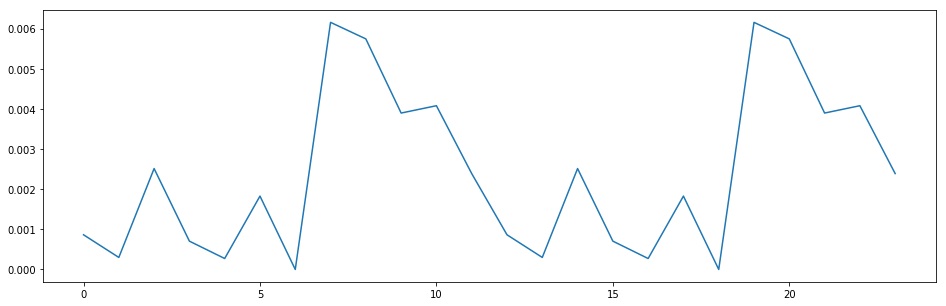

In [36]:
fig, ax = plt.subplots(figsize=(16, 5))
x = list(by_hour.keys())
x.sort()
y = [by_hour[t].theta for t in x]
ax.plot(x,y)

# Other regions of chicago

In [37]:
sides = ["Far North", "Northwest", "North", "West", "Central",
    "South", "Southwest", "Far Southwest", "Far Southeast"]

In [38]:
def load(side):
    geo = open_cp.sources.chicago.get_side(side)
    grid = open_cp.data.Grid(150, 150, 0, 0)
    grid = open_cp.geometry.mask_grid_by_intersection(geo, grid)
    mask = (all_points.timestamps >= np.datetime64("2010-01-01")) & (all_points.timestamps < np.datetime64("2011-01-01"))
    points = all_points[mask]
    points = open_cp.geometry.intersect_timed_points(points, geo)
    return grid, points

def train(grid, points):
    trainer = sepp.sepp_grid.ExpDecayTrainer(grid)
    trainer.data = add_random_noise(points)
    model = trainer.train(datetime.datetime(2011,1,1), iterations=50)
    return model

In [39]:
for side in sides:
    model = train(*load(side))
    print(side, model.theta, 24*60/model.omega, np.max(model.mu))

Far North 0.00927383306971 253.746298756 0.0246631651014
Northwest 0.00547387443326 66.7423554159 0.0274102978966


C:\Users\Matthew\Documents\m_drive\GitHub\sepp\sepp\sepp_grid.py:370: RuntimeWarning: divide by zero encountered in double_scalars
  return over / under
C:\Users\Matthew\Documents\m_drive\GitHub\sepp\sepp\sepp_grid.py:445: RuntimeWarning: invalid value encountered in multiply
  return _np.exp(- self._omega * tdelta) * self._omega * self._theta


North nan nan nan
West 0.00637429499695 29.4944726962 0.0383561643836
Central 0.0180999478941 136.220196828 0.0192295585786
South 0.0111716028646 165.265953875 0.0465753418028
Southwest 0.00548811832244 155.258712702 0.0428651775502
Far Southwest 0.00454533901518 143.751043126 0.0399384366602
Far Southeast 0.0032219164858 43.5215670091 0.0494024815598


In [40]:
def train(grid, points):
    trainer = sepp.sepp_grid.ExpDecayTrainer(grid, allow_repeats=True)
    trainer.data = points.bin_timestamps(np.datetime64("2017-01-01T12:00"), np.timedelta64(12, "h"))
    model = trainer.train(datetime.datetime(2011,1,1), iterations=50, use_fast=False)
    return model

In [41]:
for side in sides:
    model = train(*load(side))
    print(side, model.theta, 24*60/model.omega, np.max(model.mu))

Far North 1.14346083291e-08 985.285456692 0.0246575342396
Northwest 4.26253648767e-17 27881.0491102 0.027397260274
North 2.77808664667e-09 3393.37009554 0.0328767121296
West 2.20219734418e-08 8264.31394339 0.0383561628305
Central 3.2170345929e-10 1347.42322599 0.0192043895748
South 0.00164517697639 2456.97952457 0.0465292833521
Southwest 8.34418709755e-08 2061.41423615 0.0438356112433
Far Southwest 2.00322987207e-12 14609.8492034 0.0410958904108
Far Southeast 4.85757436646e-11 10911.5608999 0.0493827160462
